In [7]:
pip install pandas xlrd

   ---------------------------------------- 0.0/96.5 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/96.5 kB ? eta -:--:--
   ---------------- ----------------------- 41.0/96.5 kB 653.6 kB/s eta 0:00:01
   ---------------------------------------- 96.5/96.5 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Assignment 4 STC710: Question 1
#importing the necessary packages
import numpy as np
import seaborn as sns
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression #machine learning appraoch to linera regression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt #for data visualisation
from sklearn import preprocessing #data preprocessing
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest, f_classif #for feature selection
from sklearn.feature_selection import VarianceThreshold

In [4]:
#statsmodels library regression approach
#load data
housing_sample=pd.read_csv('housing_data_sample.csv')
housing_sample=housing_sample.drop(columns=['Id']) #just an identifier column
housing_sample=housing_sample.dropna() #dropping missing values
#print(housing_sample)
#define variables
Y=housing_sample['SalePrice']
X=housing_sample.drop(columns='SalePrice')
X=sm.add_constant(X) #add an intercept column

#fit our linear regression model
LinReg_model=sm.OLS(Y,X).fit()
print(LinReg_model.summary())


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     496.1
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        06:18:28   Log-Likelihood:                -17652.
No. Observations:                1460   AIC:                         3.532e+04
Df Residuals:                    1452   BIC:                         3.536e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -1.54e+06   9.31e+04    -16.544   

In [8]:
#linear regression using machine learning approach
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the scaled data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Fit the model
linreg = LinearRegression().fit(X_train, Y_train)

# Make predictions
y_pred = linreg.predict(X_test)

# Calculate R^2 to measure the accuracy of the model
R2 = r2_score(Y_test, y_pred)
print("R2 score:", R2)
mse_full = mse(Y_test, y_pred)
print("MSE (Full model):", mse_full)

R2 score: 0.7369310295396636
MSE (Full model): 2017824818.4196544


Original Feature Variances:
const           0.000000e+00
LotArea         9.962565e+07
YearBuilt       9.122154e+02
FullBath        3.035082e-01
TotRmsAbvGrd    2.641903e+00
GarageArea      4.571251e+04
1stFlrSF        1.494501e+05
2ndFlrSF        1.905571e+05
dtype: float64
Selected Features (Before Scaling):
Index(['LotArea', 'YearBuilt', 'FullBath', 'TotRmsAbvGrd', 'GarageArea',
       '1stFlrSF', '2ndFlrSF'],
      dtype='object')


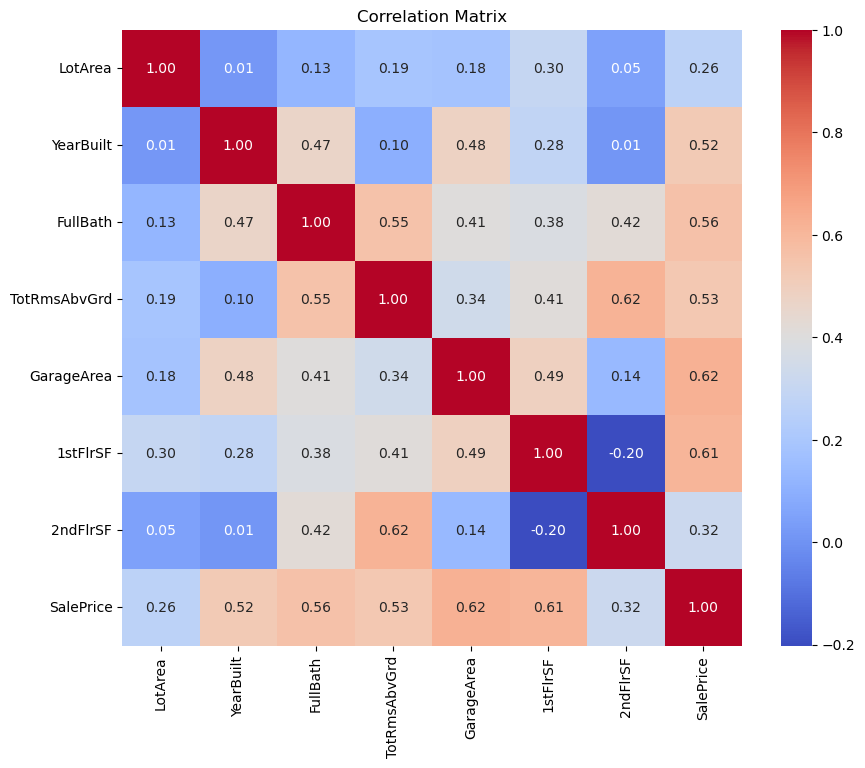

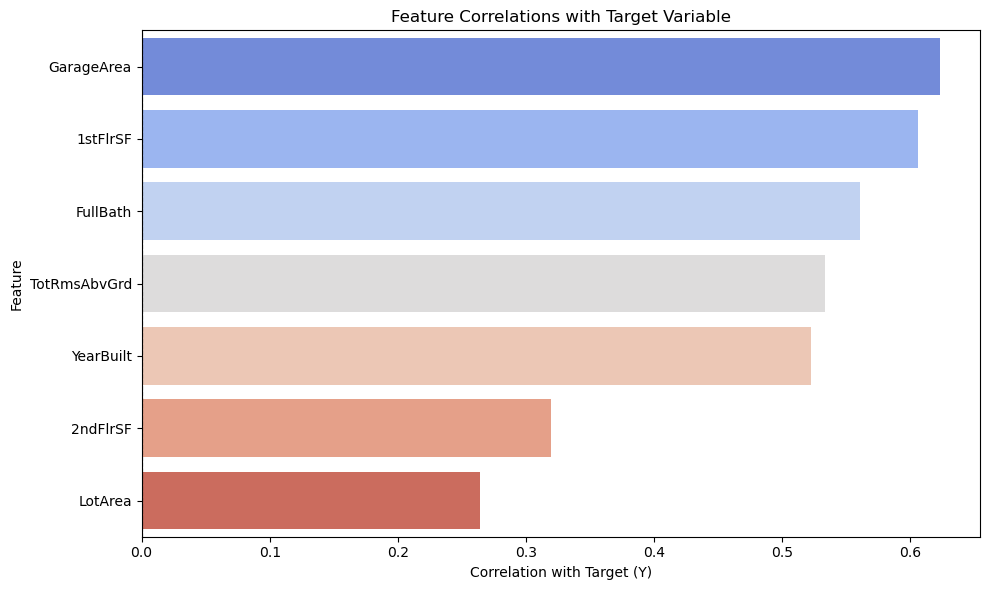

In [10]:
#Start Feature selection using variance threshold first
feature_variances_original = X.var()
print("Original Feature Variances:")
print(feature_variances_original)

#Variance Threshold on original data
selector = VarianceThreshold(threshold=0.2) 
X_selected_original = selector.fit_transform(X)

selected_features_original = X.columns[selector.get_support()]
print("Selected Features (Before Scaling):")
print(selected_features_original)

#correlation to assess feature selection
#print a correlation matrix to analyse relationships bewtween X variables and the Y variable
corr_matrix=housing_sample.corr()
#print("Correlation Matrix:",corr_matrix)
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

target_corr = housing_sample.corr()['SalePrice'].drop('SalePrice') 
corr_df = target_corr.abs().sort_values(ascending=False).to_frame(name='abs_corr')
corr_df['feature'] = corr_df.index
corr_df['corr'] = target_corr[corr_df.index]

plt.figure(figsize=(10, 6))
sns.barplot(data=corr_df, x='corr', y='feature', hue='feature', palette='coolwarm', legend=False)
plt.title('Feature Correlations with Target Variable')
plt.xlabel('Correlation with Target (Y)')
plt.ylabel('Feature')
plt.axvline(x=0, color='black', linewidth=0.8, linestyle='--')
plt.tight_layout()
plt.show()


In [12]:
#compute VIF values to see if its worth removing correlated variables
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#function to check VIFs
# compute the vif for all given features
def compute_vif(considered_features):
    
    X = housing_sample[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

# features to consider removing
considered_features = ['LotArea', 'YearBuilt', 'FullBath', 'TotRmsAbvGrd', 'GarageArea', '1stFlrSF', '2ndFlrSF']

# compute vif 
compute_vif(considered_features).sort_values('VIF', ascending=False)

,Variable,VIF
3,TotRmsAbvGrd,3.236101
6,2ndFlrSF,3.170373
5,1stFlrSF,2.879233
2,FullBath,2.136970
4,GarageArea,1.711567
1,YearBuilt,1.640775
0,LotArea,1.127200


In [16]:
df_reduced = housing_sample.drop(columns=['TotRmsAbvGrd', 'FullBath'])
Y_reduced = df_reduced['SalePrice']
X_reduced = df_reduced.drop(columns='SalePrice')

# Scale the reduced features
X_reduced_scaled = scaler.fit_transform(X_reduced)

# Split into training and testing sets
X_train_red, X_test_red, Y_train_red, Y_test_red = train_test_split(
    X_reduced_scaled, Y_reduced, test_size=0.2, random_state=42)

# Train the model
linreg_reduced = LinearRegression().fit(X_train_red, Y_train_red)

# Predict
y_pred_reduced = linreg_reduced.predict(X_test_red)

# Calculate MSE and R2
R2 = r2_score(Y_test_red, y_pred_reduced)
print("R2 score:", R2)
mse_reduced = mse(Y_test_red, y_pred_reduced)
print("MSE (Reduced model):", mse_reduced)


R2 score: 0.7362930521266233
MSE (Reduced model): 2022718313.2904906


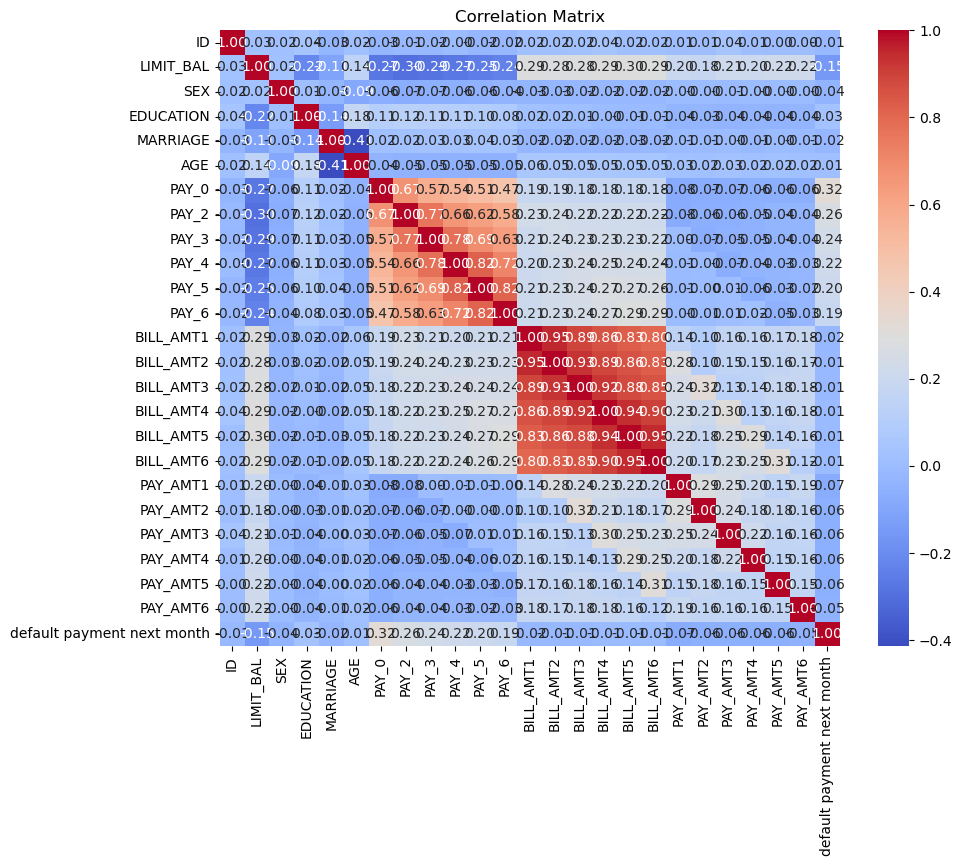

Naive Bayes Accuracy: 0.7070
Logistic Regression Accuracy: 0.8097
No-Information Rate (Pr(NIR)): 0.7812
Since the Naive Bayes model's accuracy (70.70%) is lower than the No-Information Rate (78.12%), it is not a useful model for this dataset, we should rather rely on the logistic regression model


In [26]:
#NAIVE BAYES AND LOGISTIC REGRESSION MODELS: USE CREDIT CARD DATASET
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#read in xls fil
card_df=pd.read_excel('default of credit card clients.xls', header=1)
X = card_df.drop(['ID', 'default payment next month'], axis=1)
Y = card_df['default payment next month']

corr_matrix_card=card_df.corr()
#print("Correlation Matrix:",corr_matrix)
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_card, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()
#scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split data again into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

#Naive Bayes Model
nb_model=GaussianNB()
nb_y_pred = nb_model.fit(X_train, Y_train).predict(X_test)


#Logistic Regression Model
logr_model = linear_model.LogisticRegression()
logreg_pred=logr_model.fit(X_train,Y_train).predict(X_test)

nb_acc = accuracy_score(Y_test, nb_y_pred)
log_acc = accuracy_score(Y_test, logreg_pred)

print(f"Naive Bayes Accuracy: {nb_acc:.4f}")
print(f"Logistic Regression Accuracy: {log_acc:.4f}")

#no-information rate
nir = max(Y_test.mean(), 1 - Y_test.mean())
print(f"No-Information Rate (Pr(NIR)): {nir:.4f}")

print("Since the Naive Bayes model's accuracy (70.70%) is lower than the No-Information Rate (78.12%), it is not a useful model for this dataset, we should rather rely on the logistic regression model")


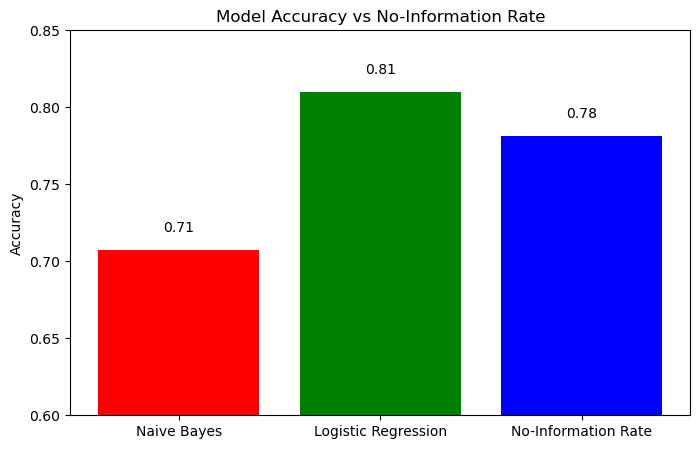

In [24]:

# Values
models = ['Naive Bayes', 'Logistic Regression', 'No-Information Rate']
accuracies = [0.7070, 0.8097, 0.7812]

# Create bar chart
plt.figure(figsize=(8,5))
bars = plt.bar(models, accuracies, color=['red', 'green', 'blue'])

# Add text labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

# Title and labels
plt.ylim(0.6, 0.85)
plt.title('Model Accuracy vs No-Information Rate')
plt.ylabel('Accuracy')
plt.savefig('q1baccuracy.png')
plt.show()
